In [2]:
import os
import torch
import torchvision
import numpy as np
import pandas as pd
from tqdm import notebook
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [3]:
# training batches of our network
EPOCHS = 10
# size of each batch
BATCH_SIZE = 512

DEVICE = ("cuda" if torch.cuda.is_available() else "cpu")
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(torch.__version__)
print(DEVICE)

1.4.0
cuda


In [4]:
train_csv = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test_csv = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')


print(train_csv.shape)
print(test_csv.shape)

(60000, 785)
(10000, 785)


In [5]:
print(train_csv.info())
print(train_csv.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 359.3 MB
None
   label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0    

In [7]:
class FashionDataset(Dataset):
    def __init__(self, data, transform=None):        
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label, image = [], []
        
        for i in self.fashion_MNIST:
            label.append(i[0])
            image.append(i[1:])
        self.labels = np.asarray(label)
        self.images = np.asarray(image).reshape(-1, 28, 28).astype('float32')
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        label = self.labels[idx]
        image = self.images[idx]      
        
        if self.transform is not None:
            # transfrom the numpy array to PIL image before the transform function
            pil_image = Image.fromarray(np.uint8(image)) 
            image = self.transform(pil_image)
            
        return image, label

In [8]:
AlexTransform = transforms.Compose([
    transforms.Resize((227, 227)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [9]:
train_loader = DataLoader(
    FashionDataset(train_csv, transform=AlexTransform), 
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = DataLoader(
    FashionDataset(test_csv, transform=AlexTransform), 
    batch_size=BATCH_SIZE, shuffle=True)

Pullover


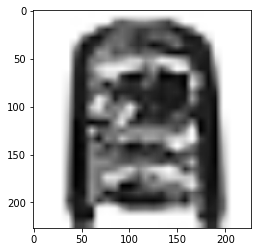

In [10]:
# helper function to show an image
def matplotlib_imshow(img):
    img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(npimg, cmap="Greys")

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# creat grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid)
print(class_names[labels[0]])

![](https://i.loli.net/2020/02/17/xd6oNRpWSK1cZy2.png)

In [11]:
class fasion_mnist_alexnet(nn.Module):  
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(96, 256, 5, 1, 2),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(256, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(384, 384, 3, 1, 1),
            nn.ReLU()
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(384, 256, 3, 1, 1),
            nn.ReLU(),
            nn.MaxPool2d(3, 2)
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
        out = out.view(out.size(0), -1)

        out = F.relu(self.fc1(out))  # 256*6*6 -> 4096
        out = F.dropout(out, 0.5)
        out = F.relu(self.fc2(out))
        out = F.dropout(out, 0.5)
        out = self.fc3(out)
        out = F.log_softmax(out, dim=1)

        return out


In [107]:
model = fasion_mnist_alexnet().to(DEVICE)
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [60]:
# train_losses = []
# test_losses = []
# epochs = 5
# for epoch in range(epochs):
#     train_loss = 0.0
#     model.train()
#     for batch_idx, (data, target) in enumerate(train_loader):
#         target = target.type(torch.LongTensor)
#         data, target = data.to(DEVICE), target.to(DEVICE)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = criterion(output, target)
#         loss.backward()
#         optimizer.step()
#         train_loss += loss.item() * data.size(0)
#         train_losses.append(train_loss/len(train_loader.dataset))
#     train_loss /= len(train_loader.dataset)
    
    
#     test_loss = 0.0
#     model.eval()
#     with torch.no_grad():
#         for batch_idx, (data, target) in enumerate(test_loader):
#             data, target = data.to(DEVICE), target.to(DEVICE)
#             output = model(data)
#             test_loss += criterion(output, target, reduction='sum').item()
#             test_losses.append(test_loss/len(test_loader.dataset))
#     test_loss /= len(test_loader.dataset)
    
    
#     print('Epoch: {}, Train Loss: {:.6f}, Test Loss: {:.6f}'.format(
#           epoch+1, train_loss, test_loss))

Epoch: 1, Train Loss: 0.055620, Test Loss: 0.365819
Epoch: 2, Train Loss: 0.047552, Test Loss: 0.414397
Epoch: 3, Train Loss: 0.057346, Test Loss: 0.377208
Epoch: 4, Train Loss: 0.048175, Test Loss: 0.406441
Epoch: 5, Train Loss: 0.054605, Test Loss: 0.368031


In [113]:
epochs = EPOCHS
train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for batch_idx, (data, target) in enumerate(notebook.tqdm(train_loader)):
        target = target.type(torch.LongTensor)
        data, target = data.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        preds = outputs.argmax(dim=1)
        running_acc += (preds == target).float().mean().item()

    train_loss.append(running_loss / len(train_loader))
    train_acc.append(running_acc / len(train_loader))

    running_loss = 0.0
    running_acc = 0.0
    model.eval()
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = model(data)
            loss = criterion(outputs, target)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            running_acc += (preds == target).float().mean().item()

    test_loss.append(running_loss / len(test_loader))
    test_acc.append(running_acc / len(test_loader))

    print(f"Epoch {epoch + 1}, Train Loss: {train_loss[-1]:.3f}, Train Acc: {train_acc[-1]:.3f}, "
          f"Test Loss: {test_loss[-1]:.3f}, Test Acc: {test_acc[-1]:.3f}")


Epoch 1, Train Loss: 0.080, Train Acc: 0.970, Test Loss: 0.300, Test Acc: 0.924



Epoch 2, Train Loss: 0.081, Train Acc: 0.971, Test Loss: 0.297, Test Acc: 0.922



Epoch 3, Train Loss: 0.076, Train Acc: 0.972, Test Loss: 0.341, Test Acc: 0.923



Epoch 4, Train Loss: 0.073, Train Acc: 0.972, Test Loss: 0.309, Test Acc: 0.922



Epoch 5, Train Loss: 0.074, Train Acc: 0.973, Test Loss: 0.320, Test Acc: 0.921



Epoch 6, Train Loss: 0.073, Train Acc: 0.974, Test Loss: 0.335, Test Acc: 0.919



Epoch 7, Train Loss: 0.059, Train Acc: 0.978, Test Loss: 0.337, Test Acc: 0.926



Epoch 8, Train Loss: 0.058, Train Acc: 0.979, Test Loss: 0.355, Test Acc: 0.921



Epoch 9, Train Loss: 0.063, Train Acc: 0.977, Test Loss: 0.365, Test Acc: 0.922



Epoch 10, Train Loss: 0.063, Train Acc: 0.978, Test Loss: 0.397, Test Acc: 0.921


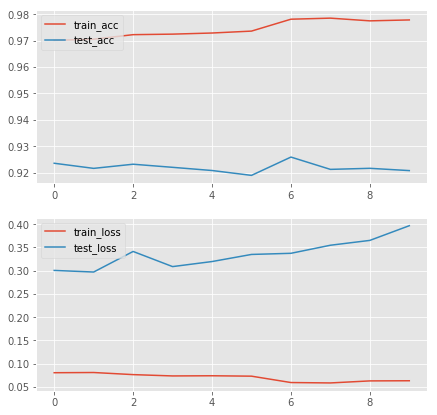

In [119]:
fig = plt.figure(figsize=[7, 7])
ax1 = plt.subplot2grid((2,1), (0,0))
ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1)
ax1.plot(train_acc, label="train_acc")
ax1.plot(test_acc, label="test_acc")
ax1.legend(loc=2)
ax2.plot(train_loss, label="train_loss")
ax2.plot(test_loss, label="test_loss")
ax2.legend(loc=2)
plt.show()